# Time Series Motif Discovery for User Interaction Logs

### Description

Time series data mining plays a crucial role in uncovering routines within user interaction logs. By analyzing sequences of user actions over time, data mining techniques can identify recurring patterns and behaviors. This allows us to understand how users typically navigate through a system, what actions they perform in sequence, and at what intervals. By uncovering these routines, we can gain valuable insights into user habits and preferences. This knowledge can then be used to optimize user interfaces, personalize experiences, and ultimately improve user satisfaction. For example, time series data mining might reveal a common sequence of actions users take to complete a specific task. This information could be used to streamline the process by suggesting the next step or automating repetitive actions.

### Functionallity of this Notebook

This notebook has three sections seperated into data preprocessing, Time Series Mining, and visualisation through Process Discovery.
As with any Jupyter Notebook you can run each cell. For the method to properly work you have to setup the first cell after the library import accordingly. This cell contains the settings of the discovery approach. The attributes to be set are described in more detail before the cell.

1. Section Preprocessing: In this section the necessery libraries are imported and the UI log is processed.
2. Section Time Series Mining: The algorithm discovers the motifs based on the setup parameters.
    - First, the UI log is encoded using our continuous hot encoding methodology.
    - Second, if you set the parameter for window size calculation the window size will be calculated. Otherwise the specified window size is used.
    - Third, the motif discovery is performed for the number of motifs you specified in the settings. 
3. The discovered motifs in the UI log are processed in a process discovery algorithm. The resulting directly follows graph is presented.

#### PreProcessing

In [1]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config

import util.util

import matplotlib.pyplot as plt
import pm4py
import webbrowser
import os

import time

#### Settings

UiLogPath >>> String: Folder path in which the UI log is stored.

UiLogFilename >>> String: Name of the UiLog.

UiLogContextColumns >>> List: List of all names that should be considered as discovery dimensions. E.g., in Agostinelli et al.s logs we have considered the columns "case:concept:name", "application", and "concept:name". In the Activity Window Tracking by Beerepoot et al. we considered the columns "Title" and "App".

TimeStampColumn >>> Str: Name of the column containing the time stamp in the UI log.

WindowSizeCalculation >>> True or False: If True the window size will be calculated using the calculation method described in our paper based on the method in 

BreakTime >>> Int: Integer representing the number of seconds that are considered as a significant user break, e.g., lunch break or break between two UI log recording sessions. Set this parameter to exclude these breaks from the window size calculation. We recommend 300 seconds, i.e., 5 minutes, as an initial start value for breaks.

ManualWindowSize >>> int: Set an integer value if the previous parameter is set to False. Otherwise a default value of 1% of the log length is choosen.

NumberOfMotifsToDiscover >>> int: Integer value ranging from 2 to infinity (possibly) as input for the discovery of multiple occurances of the motif. The result will contain the number of motifs with the closest matching distance measure independent of actual motif similiarity.

The settings are initially set for the UI log from our running example.

In [48]:
# ---- Select One of the following or set own parameters to own UI log ----
# SmartRPA
UiLogPath = "logs/smartRPA/percentageComparison/"
UiLogFilename = "LenLog_1_10_1_10_5_10_500.csv"
encoding_method = "utf-8"
seperator = ","
awt_data = False
ContextColumns = ["category","application","concept:name"] # SmartRPA / Running Example Data
timeStampColumn = "time:timestamp"
groundTruth = [492, 439, 395, 383, 210, 201, 175, 148, 141, 33]


# # XLarge Logs - Just uncomment to use these logs. Will overwrite the prvious ones
# UiLogPath = "logs/smartRPA/XLargeLogs/"
# UiLogFilename = "LenLogLong_1_0_1_10_10_0.01_1000000.csv"

# # 50% and 100% routines over log - Just uncomment to use these logs. Will overwrite the prvious ones
UiLogPath = "logs/smartRPA/p-50_100_experiment/"
UiLogFilename = "Basline-LenLog_1_vin0_no2_ro100_rlen25_p50_len5000.csv"
groundTruth = [4966, 4937, 4900, 4873, 4824, 4783, 4749, 4723, 4687, 4660, 4634, 4590, 4520, 4443, 4405, 4312, 4272, 4244, 4196, 4163, 4129, 4094, 4028, 4001, 3935, 3841, 3795, 3684, 3647, 3582, 3551, 3519, 3491, 3433, 3389, 3360, 3324, 3220, 3163, 3105, 2969, 2905, 2784, 2745, 2718, 2624, 2596, 2542, 2470, 2437, 2332, 2229, 2197, 2132, 2067, 2038, 2013, 1966, 1940, 1879, 1844, 1802, 1715, 1667, 1611, 1582, 1548, 1506, 1462, 1431, 1400, 1363, 1252, 1225, 1194, 1060, 1031, 1002, 966, 922, 851, 825, 783, 743, 710, 685, 659, 607, 536, 498, 420, 366, 340, 313, 253, 180, 143, 93, 60, 8]


# ---- Running Example SmartRPA ----
# UiLogPath = "logs/Banking/"
# UiLogFilename = "RunningExampleSmartRPA_Anonymized - Copy.csv"
# encoding_method = "utf-8"
# seperator = ";"
# awt_data = False
# ContextColumnsLong = ["category","application","event_src_path","top_level_url","title","workbook","concept:name"]  # SmartRPA / Running Example Data
# ContextColumnsShort = ["category","application","concept:name"] # SmartRPA / Running Example Data
# ContextColumns = ContextColumnsLong
# timeStampColumn = "time:timestamp"
# groundTruth = [298, 1234,2330,2662,2705,2764,2932]

# # ---- Running Example Tockler ----
# UiLogPath = "logs/Banking/"
# UiLogFilename = "RunningExampleTockler_Anonymized.csv"
# encoding_method  = "latin-1"
# seperator = ";"
# awt_data = True
# ContextColumns = ["App","Title"] # AWT Data
# timeStampColumn = "Begin"

# ---- AWT Data ----
UiLogPath = "logs/AWT/GitIgnore/"
UiLogFilename = "AWT_data_Iris_March_2023_labelled.csv"
encoding_method  = "latin-1"
seperator = ";"
awt_data = True
ContextColumns = ["App","Title"] # AWT Data
timeStampColumn = "Begin"

# ---- Configure your settings according to the approach ----
ManualWindowSize = 30
NumberOfMotifsToDiscover = 5
uiLog_Encoding_method = 3 # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Ecnoding


# ---- Window Size Calculation ---- Not in Use ----
WindowSizeCalculation = False # Not used in the final version
BreakTime = 300 # Not used in the final version

The window size was manually set and is 30.
Discovered: [ 4803  9099 13318 13350 15029]
Ground Truth:[   8   60   93  143  180  253  313  340  366  420  498  536  607  659
  685  710  743  783  825  851  922  966 1002 1031 1060 1194 1225 1252
 1363 1400 1431 1462 1506 1548 1582 1611 1667 1715 1802 1844 1879 1940
 1966 2013 2038 2067 2132 2197 2229 2332 2437 2470 2542 2596 2624 2718
 2745 2784 2905 2969 3105 3163 3220 3324 3360 3389 3433 3491 3519 3551
 3582 3647 3684 3795 3841 3935 4001 4028 4094 4129 4163 4196 4244 4272
 4312 4405 4443 4520 4590 4634 4660 4687 4723 4749 4783 4824 4873 4900
 4937 4966]
Precision: 0.0
Recall: 0.0
F1-Score: 0
Exec time: 0.6164324283599854


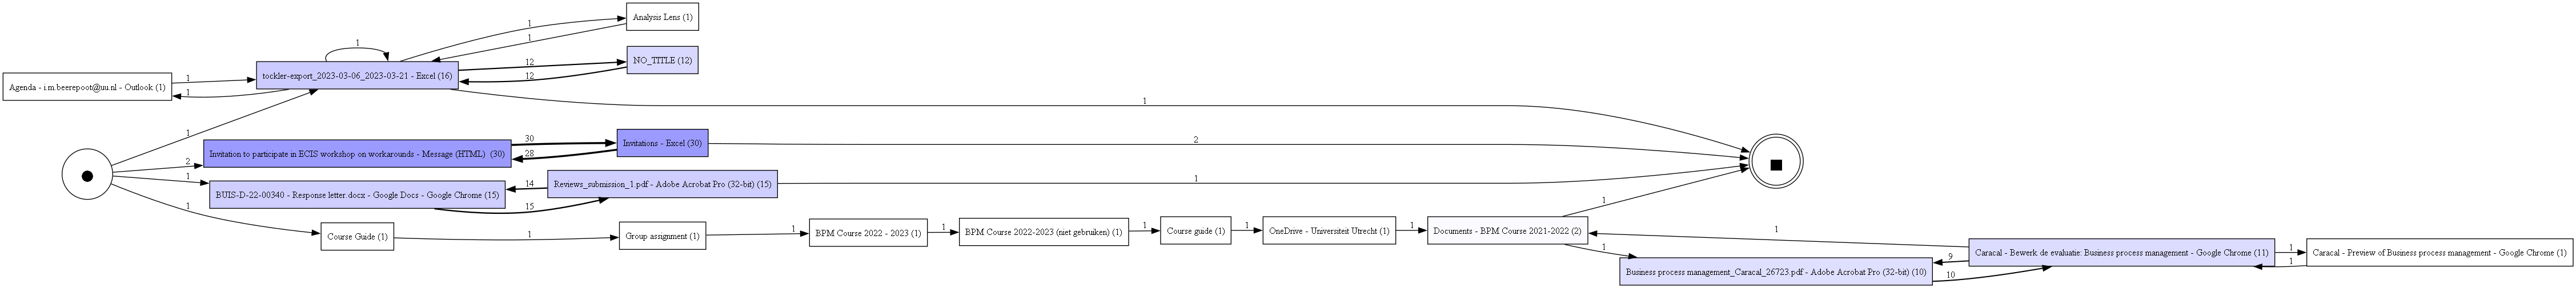

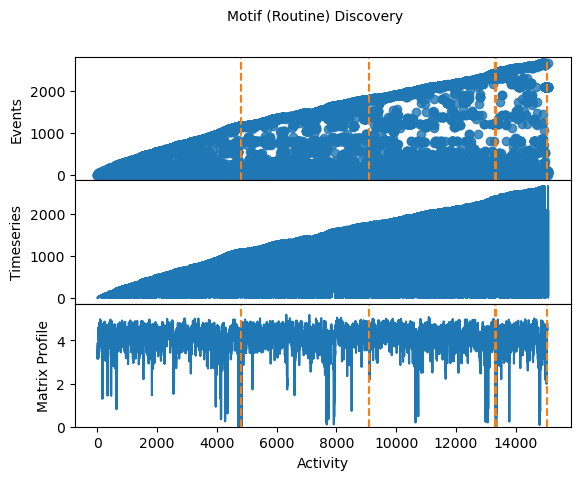

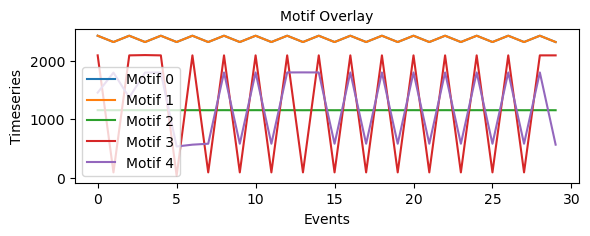

In [49]:
# ---- Do not change from here; Execute Only ----

# ---- PreProcessing ----
start_time = time.time()
file = pd.read_csv(UiLogPath + UiLogFilename, encoding=encoding_method, sep=seperator)
uiLog = util.util.encoding_UiLog(file,orderedColumnsList=ContextColumns,encoding=uiLog_Encoding_method)

if WindowSizeCalculation:
    percentil = 100
    quartile, quartile_indices, average_elements = util.util.windowSizeByBreak(file, timeStampColumn, BreakTime, percentil)
    if average_elements is not None:
        size = average_elements
        print(f"Average number of elements between breaks occurrences: {average_elements:.2f}")
    else:
        size = len(file)*0.01
        print(f"Not enough data to calculate the window size. Size will be one percent of log length: {len(file)*0.01}")
    
else:
    size = ManualWindowSize
    print(f"The window size was manually set and is {size}.")

# ---- Generating Result File Name ----
resultFile = "discoveryResults/" + UiLogFilename[:-4] + "_window_" + str(size)
encodedFile = "discoveryResults/EncodedLog" + UiLogFilename[:-4] + "_window_" + str(size)


# ---- Time Series Mining ----
tm_matrix, event_series = util.util.discover_motifs(uiLog, size, normalize=True)
# The motifs have to be exclusive, thus, no one activity must be part of a routine already discovered
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover)
# Identify the outlier
discord_idx = np.argsort(tm_matrix[:, 0])[-1]
print(f"Discovered: {np.sort(top_motifs[1][0])}")

if 'groundTruth' in locals():
    print(f"Ground Truth:{np.sort(groundTruth)}")

    insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(top_motifs[1][0]), (size/2))
    ground_truth_sum = len(groundTruth)
    true_positives = len(insert_spots)
    false_positives = NumberOfMotifsToDiscover - true_positives  # Incorrectly identified motifs
    false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

    # Precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    print(f"Precision: {precision}")

    # Recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    print(f"Recall: {recall}")

    # F1-Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"F1-Score: {f1_score}")

caseuiLog = util.util.reduceLogToDiscovered(file,top_motifs[1][0],size)
end_time = time.time()

print(f"Exec time: {end_time - start_time}")

# ---- Process Discovery ----
if awt_data == False:
    pm4pyDf = pm4py.format_dataframe(caseuiLog)
    uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
    pm4py.view_dfg(uiLogDFG, start_activities, end_activities)
    pm4py.save_vis_dfg(uiLogDFG, start_activities, end_activities, resultFile + '.png')

if awt_data == True:
    caseuiLog["concept:name"] = caseuiLog["Title"]
    caseuiLog["time:timestamp"] = caseuiLog["Begin"]
    caseuiLog['case:concept:name'] = caseuiLog['case:concept:name'].astype('int64')
    pm4pyDf = pm4py.format_dataframe(caseuiLog)
    uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
    pm4py.view_dfg(uiLogDFG, start_activities, end_activities)
    pm4py.save_vis_dfg(uiLogDFG, start_activities, end_activities, resultFile + '.png')

# ---- Motif Visualisation ----
starting_row = 0
ending_row = len(uiLog)-1
ids = uiLog.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(uiLog.loc[starting_row:ending_row,'tuple:id']))]

#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Routine) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
# Plot Matrix profiles
axs2[2].set_xlabel('Activity', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    #axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()

# ---- Store reduced UI log as csv, xes, html, DFG.pdf ----

uiLog.to_csv(encodedFile + ".csv") # Original log with encoding
caseuiLog.to_csv(resultFile + ".csv") # CSV of the discovered routines
# pm4py.write_xes(caseuiLog, resultFile + '.xes') # XES of the discovered routines
# caseuiLog.to_html(resultFile + ".html") # HTML Table of the routines
# plt.savefig(resultFile + ".pdf") # Plotted figure of overlaps

# ---- Show reduced dataframe with cases in html display ----
# webbrowser.open('file://' + os.path.realpath(resultFile + ".html"))

In [50]:
uiLog[discord_idx:discord_idx+10]

,App,Type,Title,Begin,End,Date,Time,WP flow activity,Case,Notes,tuple:id
6322,Microsoft Teams,AppTrackItem,Word | Microsoft Teams,15/03/2023 09:22,15/03/2023 09:22,15/03/2023,09:22:08,Conducting research,Active Window Tracking,NaN,322
6323,Microsoft Excel,AppTrackItem,Example categorisation - Excel,15/03/2023 09:22,15/03/2023 09:22,15/03/2023,09:22:29,Conducting research,Active Window Tracking,NaN,91
6324,Microsoft Excel,AppTrackItem,NO_TITLE,15/03/2023 09:22,15/03/2023 09:22,15/03/2023,09:22:35,Conducting research,Active Window Tracking,NaN,88
6325,Microsoft Excel,AppTrackItem,Example categorisation - Excel,15/03/2023 09:22,15/03/2023 09:22,15/03/2023,09:22:38,Conducting research,Active Window Tracking,NaN,91
6326,Microsoft Teams,AppTrackItem,Word | Microsoft Teams,15/03/2023 09:22,15/03/2023 09:22,15/03/2023,09:22:41,Conducting research,Active Window Tracking,NaN,322
6327,Microsoft Excel,AppTrackItem,NO_TITLE,15/03/2023 09:22,15/03/2023 09:23,15/03/2023,09:22:56,Conducting research,Active Window Tracking,NaN,88
6328,Microsoft Excel,AppTrackItem,Example categorisation - Excel,15/03/2023 09:23,15/03/2023 09:23,15/03/2023,09:23:05,Conducting research,Active Window Tracking,NaN,91
6329,Microsoft Teams,AppTrackItem,Word | Microsoft Teams,15/03/2023 09:23,15/03/2023 09:24,15/03/2023,09:23:08,Conducting research,Active Window Tracking,NaN,322
6330,Microsoft Excel,AppTrackItem,Example categorisation - Excel,15/03/2023 09:24,15/03/2023 09:24,15/03/2023,09:24:26,Conducting research,Active Window Tracking,NaN,91
6331,Microsoft Teams,AppTrackItem,Word | Microsoft Teams,15/03/2023 09:24,15/03/2023 09:25,15/03/2023,09:24:29,Conducting research,Active Window Tracking,NaN,322
